In [1]:
import midi2nmat as m2n
import pandas as pd
import numpy as np

In [2]:
path="/Users/wsdula/Documents/ATAVizM/Data/a-exsultate.mid"

In [3]:
test = m2n.midi2nmat(path)

In [38]:
def _make_ContCM(arr, deg1, deg2 = None):
    """
    Creates Continous Contour Matrix for searching
    Adapted for asynchrony
    """
    
    if deg2 is None:
        deg2 = deg1
    
    degrees = deg1 + deg2
    ContCM = np.zeros((degrees,len(arr))) #creates and initializes  contour matrix w/ zeroes
    ContCM.fill(np.nan)            #fills matrix with Null values
    #print(arr)
    for n in range(0,len(arr)):    
            for i in [1,2]:
                try:
                    if arr[n] > arr[n-i] and n-i >= 0 :
                        ContCM[deg1-i, n] = 1
                    elif n-i >= 0:
                        ContCM[deg1-i, n] = 0
                except:
                    continue

            for i in [1,2]:
                try:
                    if arr[n] > arr[n+i]:
                        ContCM[deg1+i-1, n] = 1
                    else:
                        ContCM[deg1+i-1, n] = 0
                except:
                    continue
    
    return ContCM

In [65]:
def _get_segments(cmin,cmax,pitches,CL_list):    
    p = []
    for n in range(cmin,cmax): #this should be a range of cardinalities to look over
        segments = [CL_list[0][i:i+n] for i in range(0, len(pitches)-n)] #get list of all possible segments of n cardinality
        segmentu = [list(x) for x in set(tuple(x) for x in segments)] #get the unique segments from the list

        segind = [[] for i in range(0,len(segmentu))] #get the index of these occurences of these segments, this also happens to be the index of the notes they start on
        for i in range(0,len(segmentu)):
            for j in range(0,len(segments)):
                if (segments[j] == segmentu[i]).all():
                    segind[i].append(j)

        if len(segments) == len(segmentu):
            break
        
        segmentucount = np.array([len(x) for x in segind]) #get a count of all the occurences for a given segment
#         segmentpitch = [pitches[ind[i][0]-2:ind[i][0]+n-1+2] for i in range(len(ind))] #get the pitches of the original occurence

        max_ind = np.argsort(segmentucount)[::-1][:5] #the indexes of the 5 most frequent segments so that the largest is in front
        max_segmentu = np.array(segmentu)[max_ind]
        max_segmentucount = segmentucount[max_ind]
#         max_segmentpitch = np.array(segmentpitch)[max_ind]
        max_segmentucov = [i*n for i in max_segmentucount]
        max_segind = np.array(segind)[max_ind]

        p.append({"segments":segments,
                  "seg":max_segmentu,
                  "segcount":max_segmentucount,
                  "segind":max_segind,
                  "segcov":max_segmentucov}) #storing the results in a data structure for later (will have index n-1)
    return p
    

In [76]:
def SAR_Contour(nmat, s_type=3, cmin=5, cmax=10, degrees=2):
    pitches=list(nmat['Pitch']) #Get the list of pitches for the piece
    contcom = _make_ContCM(pitches,degrees) #convert to continuous contour matrix
    CL = np.nansum(contcom, axis=0) #get the sums of the columns of the matrix
    
    if s_type > 1:
        durs=list(nmat['Time']) #extract beat onsets as a list
        durs=[x-y for x,y in zip(durs[1:len(durs)-1],durs[0:len(durs)-2])] #convert to interonset durations by subtracting adjacent onsets
        durs.append(nmat['Duration'].iloc[-1]) #add the duration of the last note back to list
        contcom=_make_ContCM(durs,degrees) #create continuous contour matrix
        DCL = np.nansum(contcom, axis=0) #get the sums of the columns of the matrix
        
    if s_type == 1:
        CL_list = [CL, CL]
    elif s_type == 2:
        CL_list = [DCL, DCL]
    elif s_type == 3:
        CL_list = [CL,DCL]
    
    p = _get_segments(cmin,cmax,pitches,CL_list) #makes a dataframe of all the important segments needed
    
    #initialize storage variables
#     allcov = []
    r = pd.DataFrame(columns=['card','seg','segcount','segind','cov','invind'])
    
    for i in range(0,len(p)):
        for j in range(0,len(p[i]["seg"])):
            r = r.append({"card":len(p[i]["seg"][j]),
                  "seg":p[i]["seg"][j],
                  "segcount":p[i]["segcount"][j],
                  "segind":p[i]["segind"][j],
                  "cov":p[i]["segcov"][j],
                  "invind":[]}, ignore_index=True)
#             allcov.append(p[i]["segcov"][j])
        
    r = r.sort_values(by=["cov"], ascending=False).reset_index(drop=True)
    
    return {"r":r, "p":p, "CL":CL_list, "nmat":nmat}

In [77]:
tuh = SAR_Contour(test)

In [78]:
tuh["r"]

,card,seg,segcount,segind,cov,invind
0,8,"[2.0, 4.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0]",4,"[28, 54, 169, 208]",32,[]
1,5,"[0.0, 0.0, 3.0, 1.0, 1.0]",6,"[0, 7, 48, 115, 148, 187]",30,[]
2,7,"[2.0, 4.0, 1.0, 0.0, 1.0, 2.0, 1.0]",4,"[28, 54, 169, 208]",28,[]
3,7,"[4.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0]",4,"[29, 55, 170, 209]",28,[]
4,9,"[2.0, 0.0, 2.0, 3.0, 0.0, 2.0, 1.0, 2.0, 4.0]",3,"[15, 156, 195]",27,[]
5,9,"[0.0, 0.0, 3.0, 1.0, 1.0, 3.0, 2.0, 1.0, 2.0]",3,"[7, 148, 187]",27,[]
6,9,"[2.0, 4.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0]",3,"[28, 169, 208]",27,[]
7,9,"[3.0, 2.0, 1.0, 2.0, 0.0, 2.0, 3.0, 0.0, 2.0]",3,"[12, 153, 192]",27,[]
8,9,"[0.0, 2.0, 1.0, 4.0, 3.0, 1.0, 0.0, 1.0, 4.0]",3,"[35, 176, 215]",27,[]
9,5,"[4.0, 1.0, 0.0, 1.0, 2.0]",5,"[29, 55, 71, 170, 209]",25,[]


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

def plot(nmat,segind,segcard):
    """
    plot(nmat,segind,segcard)
    ######################################################
    
    Displays Arc Plot Diagram. This consists of a series of arcs overlayed on MIDI data presented horizontally.
    
    Parameters:
        nmat (pandas.df): A Note Matrix that contains pitch, timing, and velocity information for a series of notes.
        nmatRCE (pandas.df): A version of the Note Matrix which has each element reduced to a binary value.
        onsets (list): A list of values that describes when each note would begin in the piece.
        offsets (list): A list of values that describes when each note would end in the piece.
        segind (list): A list of lists of values that describe the occurences of each pattern found in the piece.
        segcard (list): A list that describes how many notes should be in each pattern.
    """
    
    onsets = nmat['Time']
    offsets = onsets + nmat['Duration']
    pitch = nmat['Pitch']
    
    _midiplot(onsets,offsets,pitch)

    colornum=1
    #cmap1=jet(len(segcard))
    #cmap1 = plt.cm.get_cmap('jet')
    pitchmean=nmat['Pitch'].mean()

    #segind=[1,72,161,244,264,382,517,726]
    framelabels = ["Onset in Beats", "Durations in Beats", "Pitch (C4=60)"]
    #segcard=20
    rads = [1]
    # for i in range(0,len(segind)-1):
    try:
        ind=segind
    finally:
        pass
    #     try
    #         try
    #             simind=r(i).simind;
    #         catch
    #             simind=r(i).invind;
    #         end
    #     catch
    #         simind=[];
    #     end
    #       ind
    origxstart = nmat.iloc[segind[0],0]
    card=segcard
    origxend=nmat.iloc[(segind[0] + card - 1),0] + nmat.iloc[(segind[0] + card - 1),1]
    origwidth=origxend - origxstart
    origx=(origwidth) / 2 + origxstart
    linewidthstart= origwidth #need to normalize to pixel length
    origpitchmin=min(nmat.iloc[segind[0]:(segind[0] + card - 1),2]) - 2
    colornoalpha=[colornum]
    colornum=colornum + 1
    
    for j in range(1,len(ind)):
        noteInd = ind[j]-1
        compxstart=nmat.iloc[noteInd,0]
        compxend=nmat.iloc[noteInd + (card - 1),0] + nmat.iloc[noteInd + (card - 1),1]
        compwidth=compxend - compxstart
        compx=(compwidth) / 2 + compxstart
        linewidthend= compwidth #need to normalize to pixel length
        comppitchmin=min(nmat.iloc[noteInd:noteInd + (card - 1),2]) - 2
        rad=(compx - origx) / 2
        rads.append(rad)
        x=rad + origx
        nsegments=100
        linewidth=np.dot(card,3)
        
        if segcard:
            colornoalpha=[0,0,1]
            
        coloralpha=colornoalpha.append(0.5)
        _arc(x=x,y=pitchmean,r=rad,linewidthstart=linewidthstart,linewidthend=linewidthend)

def _arc(x,y,r,nsegments=100,coloralpha='r',linewidthstart=5,linewidthend=10):
    """
    _arc(x,y,r,nsegments=100,coloralpha='r',linewidthstart=5,linewidthend=10)
    #########################################################################
    
    Draws an arc from one point to another.
    
    Parameters:
        x (float): The time value the arc will start at.
        y (float): The pitch value the arc will start at.
        r (float): The radius of the arc.
        nsegments (int): The number of line segments that make up the arc.
        coloralpha (str): The color of the line segments.
        linewidthstart (int): the width of each line segment at the beginning.
        linewidthend (int): the width of each line segment at the end.
    """
    th=np.arange(0,np.pi,np.pi/100)
    xunit=r * np.cos(th) + x;
    yunit=r * np.sin(th) + y;
    linewidthincrement=(linewidthstart-linewidthend)/len(xunit);

    plt.figure(1)
    for i in range(2,len(th)):
        plt.plot([xunit[i-1],xunit[i]], [yunit[i-1],yunit[i]],coloralpha,linewidth = linewidthend+i*linewidthincrement, zorder=0)
        
def _midiplot(onsets,offsets,pitch):
    plt.figure(figsize=(20,10))
    
    for i in range(0,len(onsets)):
        plt.plot([onsets[i],offsets[i]], [pitch[i],pitch[i]], 'g', lw=2, path_effects=[pe.Stroke(linewidth=5, foreground='g'), pe.Normal()], zorder=5)

    plt.xlabel("Beats")
    plt.ylabel("Pitch (C4=60)")

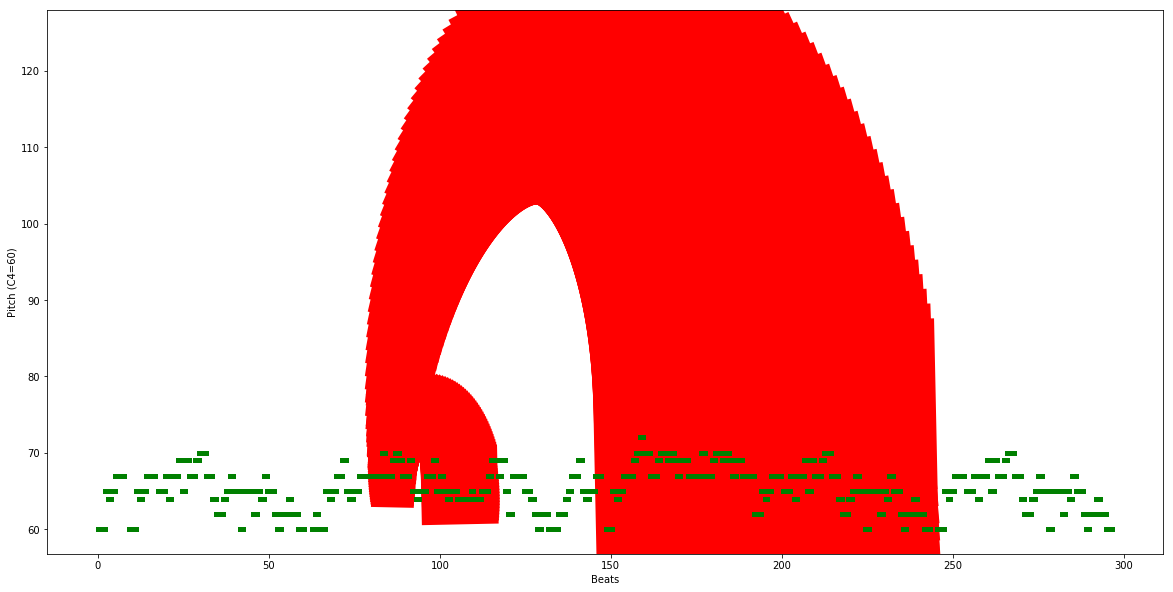

In [110]:
plot(test,tuh["r"]['segind'].iloc[0],tuh["r"]['card'].iloc[0])